In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()







In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}




data_dir = '/content/drive/MyDrive/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=8)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
print (dataset_sizes)


{'train': 3265, 'test': 810}


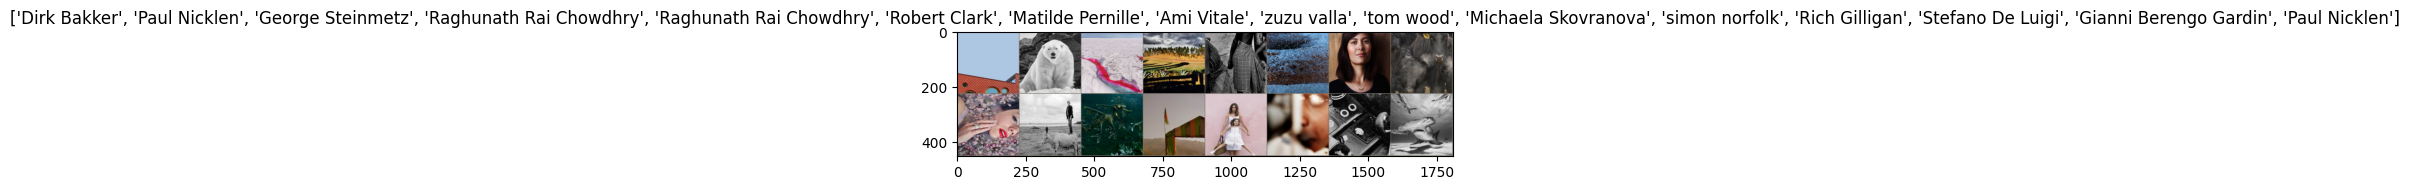

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
import tqdm
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    #best_model_wts = copy.deepcopy(model_.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm.tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best test Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
models=torchvision.models.resnet18(pretrained=True)
num_ftrs = models.fc.in_features

models.fc = nn.Linear(num_ftrs, 48)

models = models.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_fc = optim.SGD(models.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_fc, step_size=7, gamma=0.1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 212MB/s]


In [ ]:
models

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
 train_model(models, criterion, optimizer_fc, exp_lr_scheduler,num_epochs=10)

Epoch 0/9
----------


 87%|████████▋ | 178/205 [01:34<00:07,  3.49it/s]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:44<00:00,  1.96it/s]


train Loss: 3.6314 Acc: 0.0983


100%|██████████| 51/51 [00:25<00:00,  1.98it/s]


test Loss: 3.3592 Acc: 0.1580

Epoch 1/9
----------


 13%|█▎        | 27/205 [00:15<01:01,  2.88it/s]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:47<00:00,  1.90it/s]


train Loss: 3.0288 Acc: 0.2521


100%|██████████| 51/51 [00:25<00:00,  1.98it/s]


test Loss: 3.0199 Acc: 0.2321

Epoch 2/9
----------


 45%|████▌     | 93/205 [00:51<00:58,  1.93it/s]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:43<00:00,  1.98it/s]


train Loss: 2.7162 Acc: 0.3210


100%|██████████| 51/51 [00:25<00:00,  1.98it/s]


test Loss: 2.8697 Acc: 0.2679

Epoch 3/9
----------


 38%|███▊      | 78/205 [00:44<00:33,  3.83it/s]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:45<00:00,  1.94it/s]


train Loss: 2.5073 Acc: 0.3651


100%|██████████| 51/51 [00:25<00:00,  1.97it/s]


test Loss: 2.8431 Acc: 0.2667

Epoch 4/9
----------


  1%|▏         | 3/205 [00:04<03:49,  1.13s/it]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:45<00:00,  1.95it/s]


train Loss: 2.3505 Acc: 0.3917


100%|██████████| 51/51 [00:25<00:00,  1.98it/s]


test Loss: 2.7069 Acc: 0.2963

Epoch 5/9
----------


 59%|█████▉    | 121/205 [01:04<00:33,  2.52it/s]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:43<00:00,  1.98it/s]


train Loss: 2.2721 Acc: 0.4132


100%|██████████| 51/51 [00:25<00:00,  1.99it/s]


test Loss: 2.6824 Acc: 0.2988

Epoch 6/9
----------


 87%|████████▋ | 178/205 [01:35<00:05,  4.68it/s]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:45<00:00,  1.94it/s]


train Loss: 2.1797 Acc: 0.4374


100%|██████████| 51/51 [00:25<00:00,  1.98it/s]


test Loss: 2.6246 Acc: 0.2988

Epoch 7/9
----------


 13%|█▎        | 27/205 [00:16<00:51,  3.47it/s]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:45<00:00,  1.93it/s]


train Loss: 2.0812 Acc: 0.4640


100%|██████████| 51/51 [00:25<00:00,  1.97it/s]


test Loss: 2.5818 Acc: 0.3309

Epoch 8/9
----------


 58%|█████▊    | 118/205 [01:02<00:38,  2.24it/s]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:43<00:00,  1.98it/s]


train Loss: 2.0623 Acc: 0.4662


100%|██████████| 51/51 [00:28<00:00,  1.82it/s]


test Loss: 2.5698 Acc: 0.3407

Epoch 9/9
----------


 84%|████████▍ | 172/205 [01:31<00:09,  3.31it/s]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:47<00:00,  1.92it/s]


train Loss: 2.0426 Acc: 0.4695


100%|██████████| 51/51 [00:26<00:00,  1.94it/s]

test Loss: 2.5814 Acc: 0.3358

Training complete in 21m 54s
Best test Acc: 0.340741


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

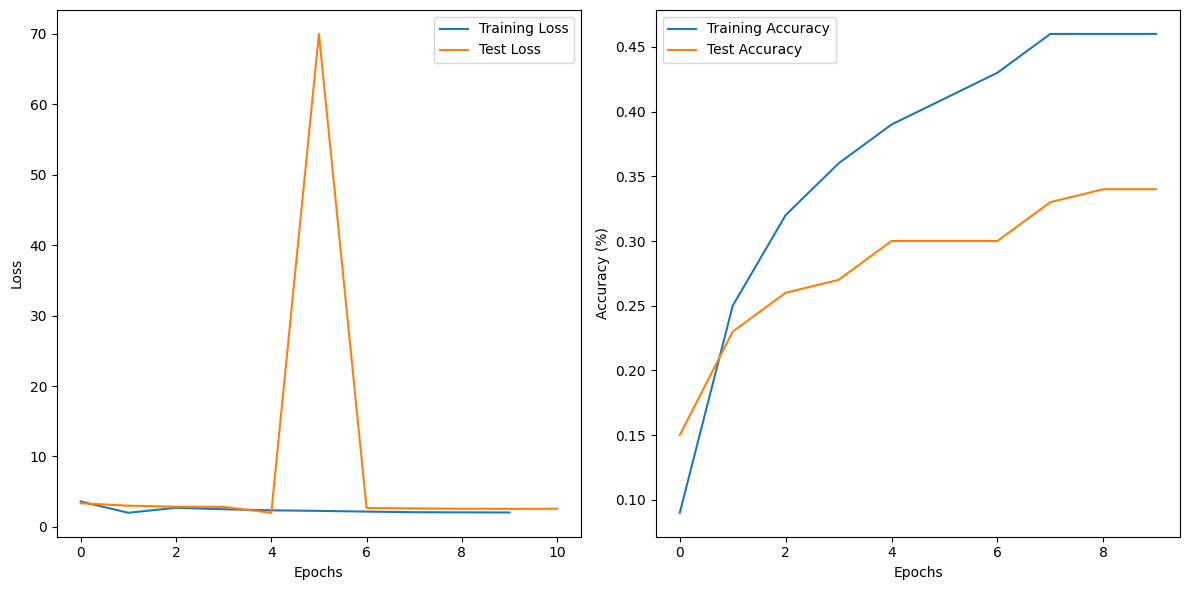

In [ ]:
import matplotlib.pyplot as plt

# Example data for losses and accuracies
training_losses = [3.6, 2.0, 2.71, 2.50, 2.35,2.27,2.17,2.08, 2.06, 2.04]
test_losses = [3.35, 3.01, 2.86, 2.84, 2,70, 2.68, 2.62, 2.58, 2.56, 2.58]
training_accuracies = [0.09,0.25,0.32,0.36,0.39,0.41,0.43,0.46,0.46,0.46]
test_accuracies = [0.15,0.23,0.26,0.27,0.30,0.30,0.30,0.33,0.34,0.34]

# Plotting
plt.figure(figsize=(12, 6))

# Plot Training and Test Loss
plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


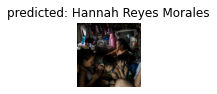

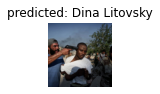

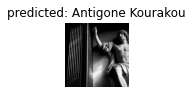

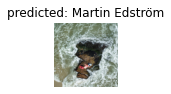

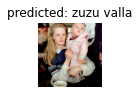

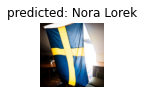

In [ ]:
visualize_model(models)

In [ ]:
!pip install scikit-learn

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


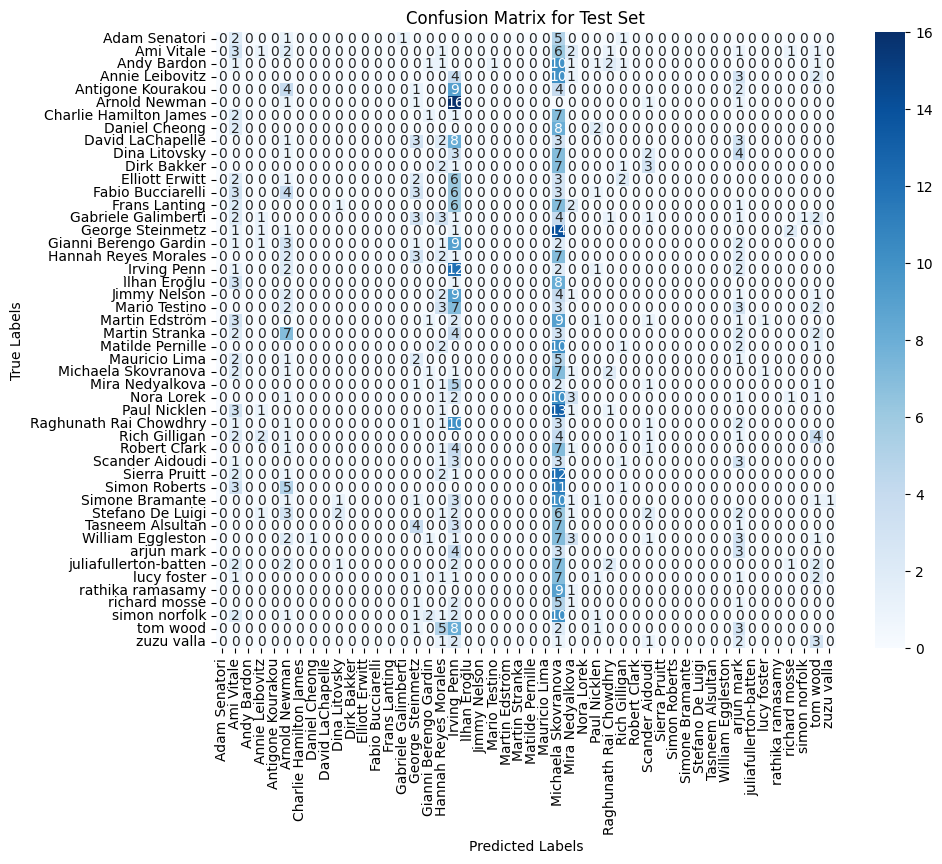

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np # Import numpy

def compute_confusion_matrix(model):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Save confusion matrix to a file
    np.savetxt("confusion_matrix.csv", conf_matrix, delimiter=",")

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for Test Set')
    plt.show()

# Compute and plot the confusion matrix
compute_confusion_matrix(models)

In [ ]:
import numpy as np
import pandas as pd
import os

# Load confusion matrix CSV (48x48)
cm = np.loadtxt("confusion_matrix.csv", delimiter=",")

# Check shape to confirm 48 classes
num_classes = cm.shape[0]
print(f"Confusion matrix shape: {cm.shape}")

if num_classes != 48:
    raise ValueError("Confusion matrix is not 48x48!")

# Replace this with your actual list of 48 class names in correct order
class_names = [
    "Adam Senatori", "Ami Vitale", "Andy Bardon", "Annie Leibovitz", "Antigone Kourakou",
    "Arnold Newman", "Charlie Hamilton James", "Daniel Cheong", "David LaChapelle", "Dina Litovsky",
    "Dirk Bakker", "Elliott Erwitt", "Fabio Bucciarelli", "Frans Lanting", "Gabriele Galimberti",
    "George Steinmetz", "Gianni Berengo Gardin", "Hannah Reyes Morales", "Irving Penn", "İlhan Eroğlu",
    "Jimmy Nelson", "Mario Testino", "Martin Edström", "Martin Stranka", "Matilde Pernille",
    "Mauricio Lima", "Michaela Skovranova", "Mira Nedyalkova", "Nora Lorek", "Paul Nicklen",
    "Raghunath Rai Chowdhry", "Rich Gilligan", "Robert Clark", "Scander Aidoudi", "Sierra Pruitt",
    "Simon Roberts", "Simone Bramante", "Stefano De Luigi", "Tasneem Alsultan", "William Eggleston",
    "Arjun Mark", "Julia Fullerton-Batten", "Lucy Foster", "Rathika Ramasamy", "Richard Mosse",
    "Simon Norfolk", "Tom Wood", "Zuzu Valla"
]

if len(class_names) != 48:
    raise ValueError("class_names list does not contain 48 names!")

# Calculate TP, FP, FN, TN
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = np.sum(cm) - (TP + FP + FN)

# Calculate precision, recall, f1-score
epsilon = 1e-10
precision = TP / (TP + FP + epsilon)
recall = TP / (TP + FN + epsilon)
f1 = 2 * precision * recall / (precision + recall + epsilon)

# Create DataFrame for results
results = pd.DataFrame({
    'Class': class_names,
    'TP': TP,
    'FP': FP,
    'FN': FN,
    'TN': TN,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

# Set class names as index if you prefer
results.set_index('Class', inplace=True)

# Save to CSV
results.to_csv("class_metrics.csv")

# Display the results DataFrame
display(results)

FileNotFoundError: confusion_matrix.csv not found.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Use the existing 'results' DataFrame
# Calculate metrics (already done in the cell that created 'results', but recalculating for clarity)
results["Precision"] = results["TP"] / (results["TP"] + results["FP"])
results["Recall"] = results["TP"] / (results["TP"] + results["FN"])
results["F1-Score"] = 2 * results["Precision"] * results["Recall"] / (results["Precision"] + results["Recall"])
results.fillna(0, inplace=True)

# Top 5 classes by F1-Score
top5 = results.sort_values("F1-Score", ascending=False).head(5)

# Plot
top5[["TP", "FP", "FN", "TN"]].plot(kind="bar", figsize=(12, 6), colormap="Set2")
plt.title("TP, FP, FN, TN for Top 5 Classes by F1-Score")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

NameError: name 'results' is not defined

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


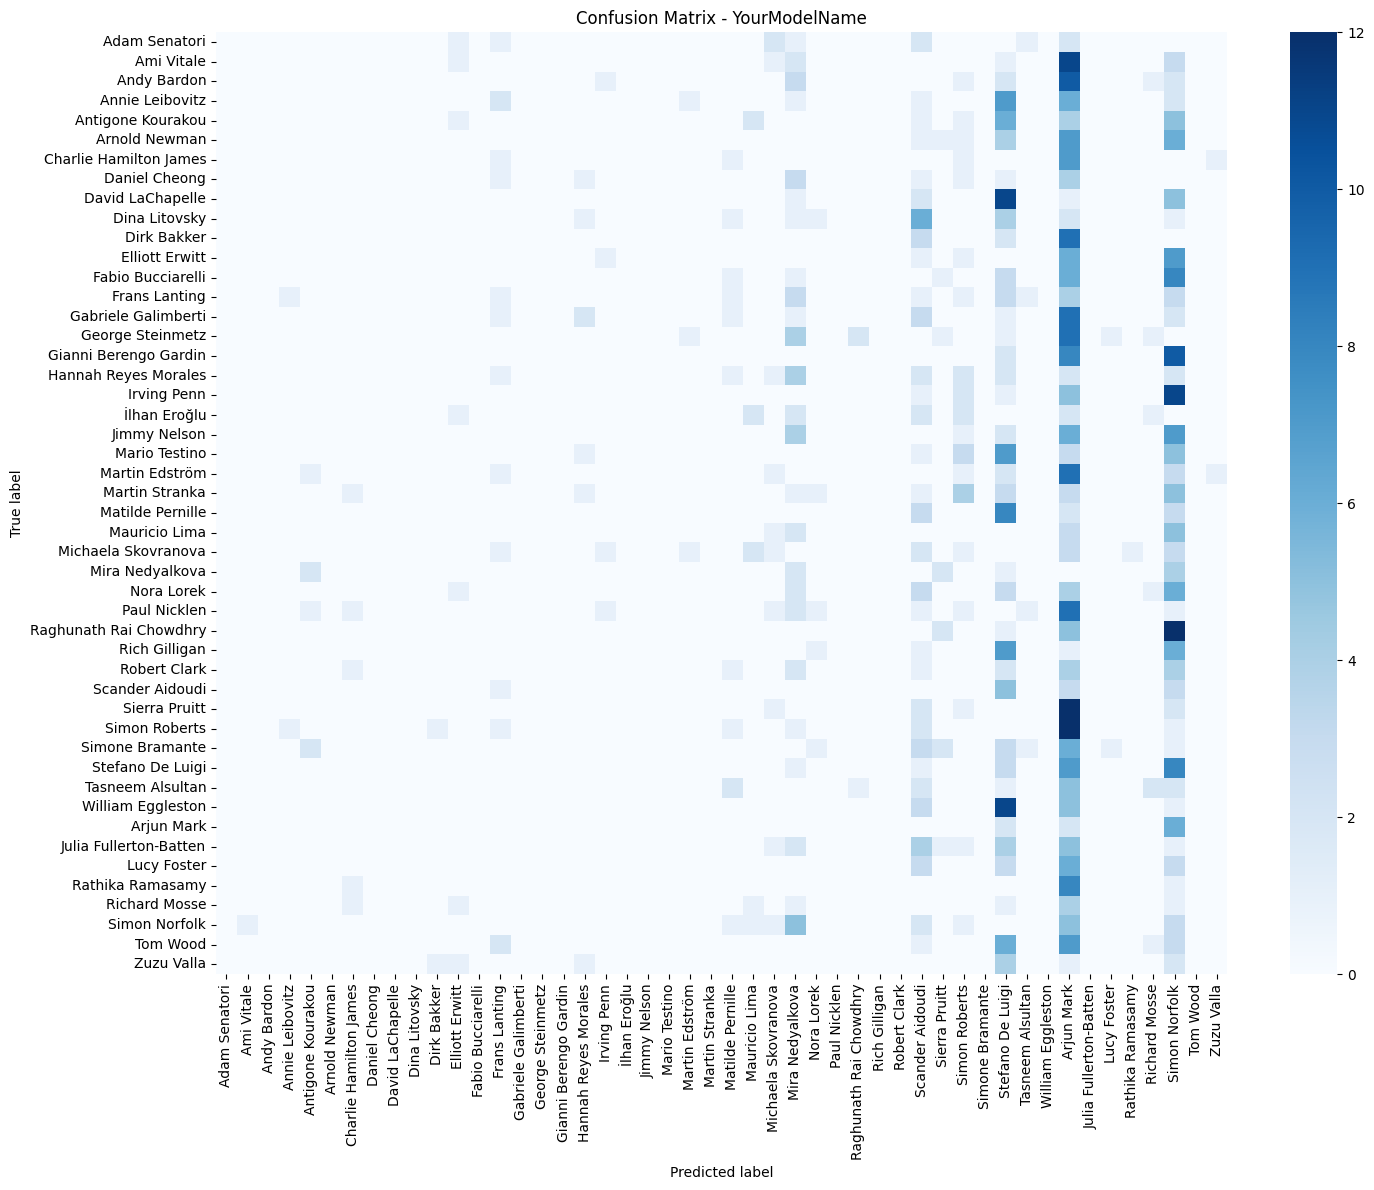

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch # Import torch

# Example: Replace with your true and predicted labels
# For 48 classes, y_true and y_pred should contain integers from 0 to 47
y_true = []  # e.g., [0, 1, 2, 1, 0, ...] (length = number of test samples)
y_pred = []  # e.g., [0, 2, 1, 1, 0, ...]

# Populate y_true and y_pred from the test dataloader
models.eval() # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = models(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


# Optional: Provide class names if you have them
class_names = [
    "Adam Senatori", "Ami Vitale", "Andy Bardon", "Annie Leibovitz", "Antigone Kourakou",
    "Arnold Newman", "Charlie Hamilton James", "Daniel Cheong", "David LaChapelle", "Dina Litovsky",
    "Dirk Bakker", "Elliott Erwitt", "Fabio Bucciarelli", "Frans Lanting", "Gabriele Galimberti",
    "George Steinmetz", "Gianni Berengo Gardin", "Hannah Reyes Morales", "Irving Penn", "İlhan Eroğlu",
    "Jimmy Nelson", "Mario Testino", "Martin Edström", "Martin Stranka", "Matilde Pernille",
    "Mauricio Lima", "Michaela Skovranova", "Mira Nedyalkova", "Nora Lorek", "Paul Nicklen",
    "Raghunath Rai Chowdhry", "Rich Gilligan", "Robert Clark", "Scander Aidoudi", "Sierra Pruitt",
    "Simon Roberts", "Simone Bramante", "Stefano De Luigi", "Tasneem Alsultan", "William Eggleston",
    "Arjun Mark", "Julia Fullerton-Batten", "Lucy Foster", "Rathika Ramasamy", "Richard Mosse",
    "Simon Norfolk", "Tom Wood", "Zuzu Valla"
] # Replace with real class names if available


# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(48))

# Plot the confusion matrix
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - YourModelName')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

<Figure size 2200x1000 with 0 Axes>

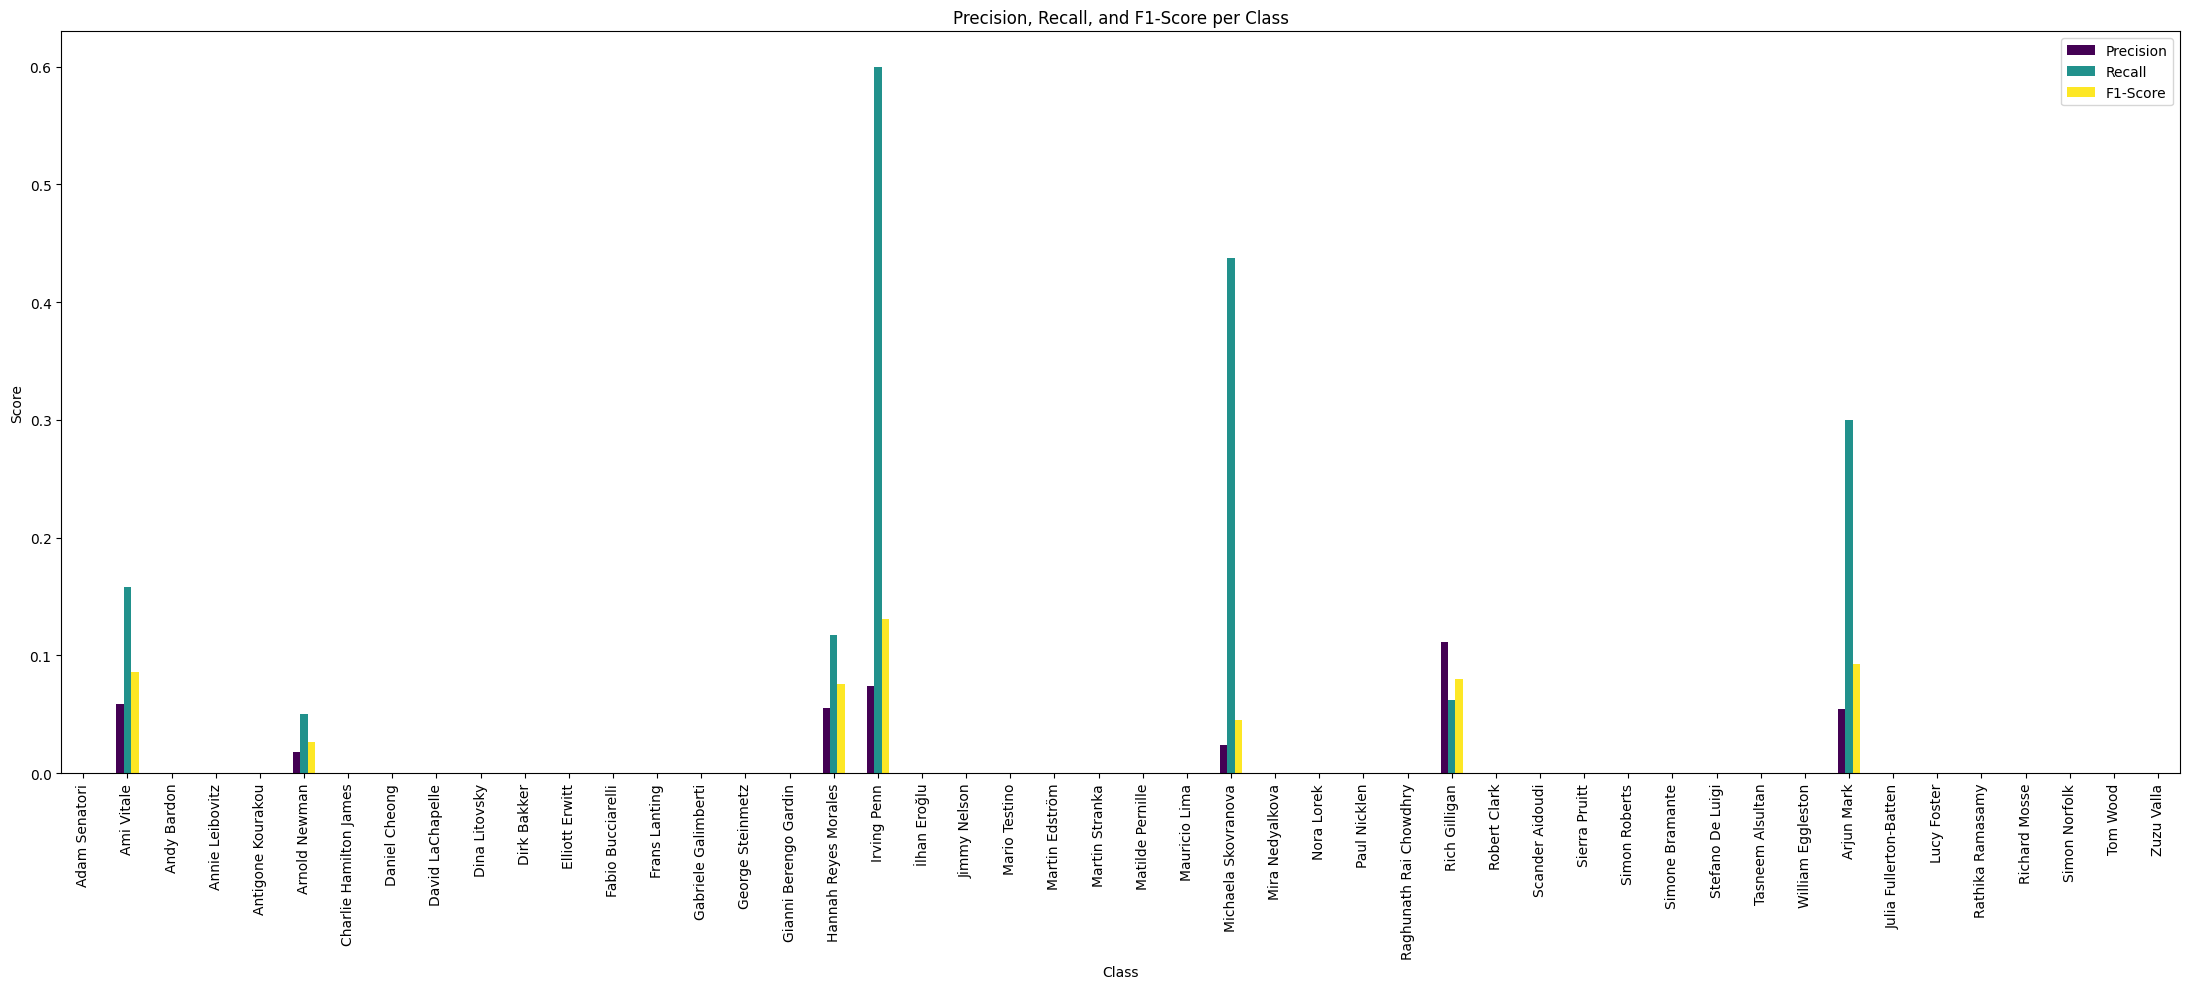

In [ ]:
plt.figure(figsize=(22, 10))
metrics = ['Precision', 'Recall', 'F1-Score']
results_plot = results[metrics]

results_plot.plot(kind='bar', figsize=(22, 10), colormap='viridis')
plt.xticks(rotation=90)
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score per Class')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [ ]:
models=torchvision.models.resnet18 (pretrained=True)
for param in models.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = models.fc.in_features
models.fc = nn.Linear(num_ftrs, 48)

models = models.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_fc = optim.SGD(models.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_fc, step_size=7, gamma=0.1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
models

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
train_model(models, criterion, optimizer_fc,exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


 85%|████████▌ | 175/205 [01:31<00:08,  3.36it/s]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:44<00:00,  1.97it/s]


train Loss: 3.6157 Acc: 0.1081


100%|██████████| 51/51 [00:26<00:00,  1.93it/s]


test Loss: 3.3665 Acc: 0.1630

Epoch 1/9
----------


 28%|██▊       | 57/205 [00:33<01:18,  1.87it/s]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:46<00:00,  1.93it/s]


train Loss: 3.0380 Acc: 0.2346


100%|██████████| 51/51 [00:26<00:00,  1.91it/s]


test Loss: 3.0302 Acc: 0.2296

Epoch 2/9
----------


 44%|████▍     | 90/205 [00:50<01:08,  1.67it/s]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:45<00:00,  1.93it/s]


train Loss: 2.7118 Acc: 0.3173


100%|██████████| 51/51 [00:26<00:00,  1.95it/s]


test Loss: 2.8881 Acc: 0.2531

Epoch 3/9
----------


 59%|█████▊    | 120/205 [01:01<00:24,  3.49it/s]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:43<00:00,  1.98it/s]


train Loss: 2.4877 Acc: 0.3789


100%|██████████| 51/51 [00:26<00:00,  1.93it/s]


test Loss: 2.7733 Acc: 0.2605

Epoch 4/9
----------


 79%|███████▊  | 161/205 [01:26<00:19,  2.27it/s]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:46<00:00,  1.93it/s]


train Loss: 2.3805 Acc: 0.3819


100%|██████████| 51/51 [00:26<00:00,  1.94it/s]


test Loss: 2.6917 Acc: 0.3012

Epoch 5/9
----------


 56%|█████▌    | 115/205 [01:00<00:24,  3.65it/s]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:46<00:00,  1.93it/s]


train Loss: 2.2447 Acc: 0.4168


100%|██████████| 51/51 [00:26<00:00,  1.95it/s]


test Loss: 2.7032 Acc: 0.3025

Epoch 6/9
----------


 31%|███       | 64/205 [00:34<00:46,  3.01it/s]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:42<00:00,  1.99it/s]


train Loss: 2.2021 Acc: 0.4211


100%|██████████| 51/51 [00:25<00:00,  1.98it/s]


test Loss: 2.6142 Acc: 0.3321

Epoch 7/9
----------


 52%|█████▏    | 106/205 [00:58<00:39,  2.48it/s]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:43<00:00,  1.98it/s]


train Loss: 2.0803 Acc: 0.4459


100%|██████████| 51/51 [00:25<00:00,  1.97it/s]


test Loss: 2.5792 Acc: 0.3173

Epoch 8/9
----------


 38%|███▊      | 78/205 [00:40<00:44,  2.86it/s]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:43<00:00,  1.97it/s]


train Loss: 2.0566 Acc: 0.4732


100%|██████████| 51/51 [00:25<00:00,  1.99it/s]


test Loss: 2.5879 Acc: 0.3148

Epoch 9/9
----------


 78%|███████▊  | 160/205 [01:22<00:13,  3.36it/s]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:41<00:00,  2.02it/s]


train Loss: 2.0632 Acc: 0.4714


100%|██████████| 51/51 [00:25<00:00,  2.00it/s]

test Loss: 2.5787 Acc: 0.3123

Training complete in 21m 45s
Best test Acc: 0.332099


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

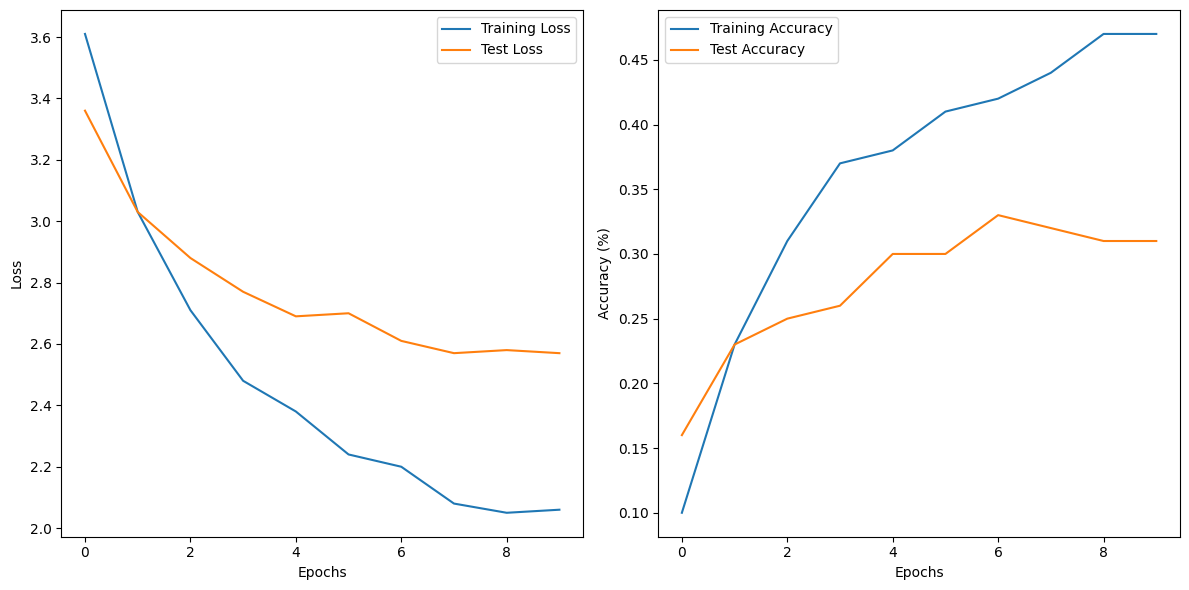

In [ ]:
import matplotlib.pyplot as plt

# Example data for losses and accuracies
training_losses = [3.61,3.03,2.71,2.48,2.38,2.24,2.20,2.08,2.05,2.06]
test_losses = [3.36,3.03,2.88,2.77,2.69,2.70,2.61,2.57,2.58,2.57]
training_accuracies = [0.10,0.23,0.31,0.37,0.38,0.41,0.42,0.44,0.47,0.47]
test_accuracies = [0.16,0.23,0.25,0.26,0.30,0.30,0.33,0.32,0.31,0.31]

# Plotting
plt.figure(figsize=(12, 6))

# Plot Training and Test Loss
plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
models

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

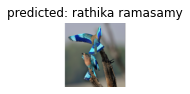

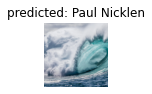

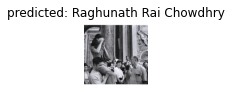

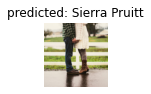

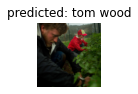

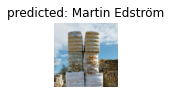

In [ ]:
visualize_model(models)

plt.ioff()
plt.show()

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


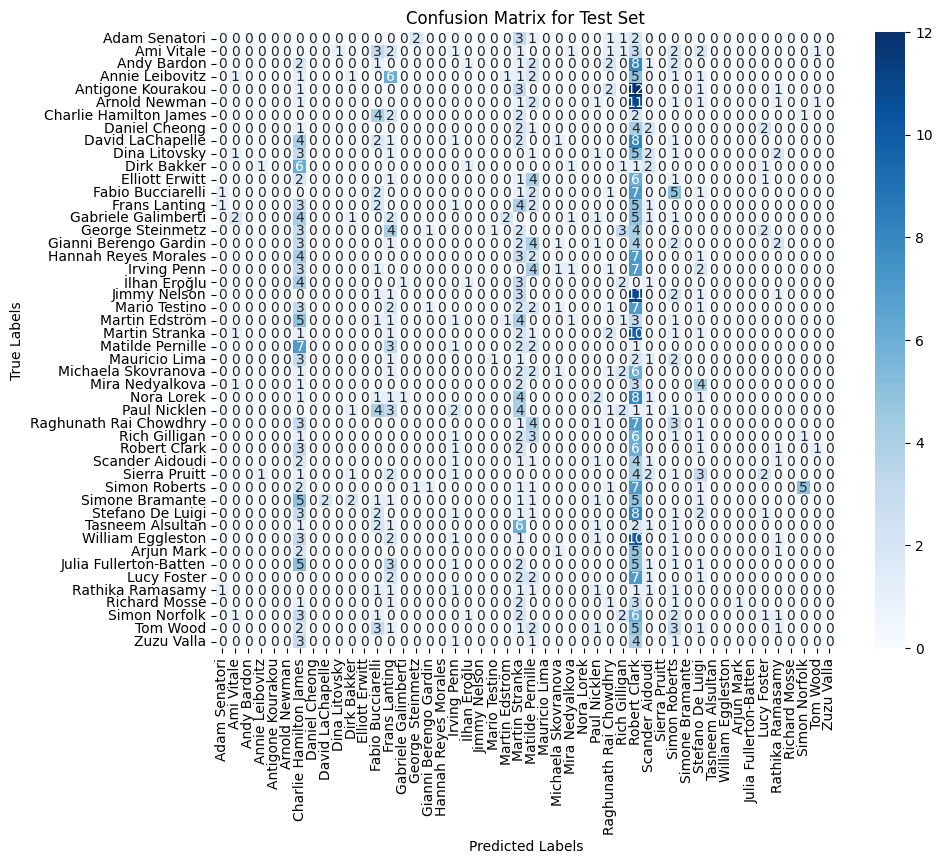

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np



def compute_confusion_matrix(model):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    np.savetxt("confusion_matrix.csv", conf_matrix, delimiter=",")

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for Test Set')
    plt.show()

# Compute and plot the confusion matrix
compute_confusion_matrix(models)

In [ ]:
import numpy as np
import pandas as pd
import os

# Load confusion matrix CSV (48x48)
cm = np.loadtxt("confusion_matrix.csv", delimiter=",")

# Check shape to confirm 48 classes
num_classes = cm.shape[0]
print(f"Confusion matrix shape: {cm.shape}")

if num_classes != 48:
    raise ValueError("Confusion matrix is not 48x48!")

# Replace this with your actual list of 48 class names in correct order
class_names = [
    "Adam Senatori", "Ami Vitale", "Andy Bardon", "Annie Leibovitz", "Antigone Kourakou",
    "Arnold Newman", "Charlie Hamilton James", "Daniel Cheong", "David LaChapelle", "Dina Litovsky",
    "Dirk Bakker", "Elliott Erwitt", "Fabio Bucciarelli", "Frans Lanting", "Gabriele Galimberti",
    "George Steinmetz", "Gianni Berengo Gardin", "Hannah Reyes Morales", "Irving Penn", "İlhan Eroğlu",
    "Jimmy Nelson", "Mario Testino", "Martin Edström", "Martin Stranka", "Matilde Pernille",
    "Mauricio Lima", "Michaela Skovranova", "Mira Nedyalkova", "Nora Lorek", "Paul Nicklen",
    "Raghunath Rai Chowdhry", "Rich Gilligan", "Robert Clark", "Scander Aidoudi", "Sierra Pruitt",
    "Simon Roberts", "Simone Bramante", "Stefano De Luigi", "Tasneem Alsultan", "William Eggleston",
    "Arjun Mark", "Julia Fullerton-Batten", "Lucy Foster", "Rathika Ramasamy", "Richard Mosse",
    "Simon Norfolk", "Tom Wood", "Zuzu Valla"
]

if len(class_names) != 48:
    raise ValueError("class_names list does not contain 48 names!")

# Calculate TP, FP, FN, TN
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = np.sum(cm) - (TP + FP + FN)

# Calculate precision, recall, f1-score
epsilon = 1e-10
precision = TP / (TP + FP + epsilon)
recall = TP / (TP + FN + epsilon)
f1 = 2 * precision * recall / (precision + recall + epsilon)

# Create DataFrame for results
results = pd.DataFrame({
    'Class': class_names,
    'TP': TP,
    'FP': FP,
    'FN': FN,
    'TN': TN,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

# Set class names as index if you prefer
results.set_index('Class', inplace=True)

# Save to CSV
results.to_csv("class_metrics.csv")

# Print first 10 rows to check
print(results.head(48))


Confusion matrix shape: (48, 48)
                         TP     FP    FN     TN  Precision    Recall  F1-Score
Class                                                                         
Adam Senatori           0.0    3.0  10.0  797.0   0.000000  0.000000  0.000000
Ami Vitale              0.0    7.0  19.0  784.0   0.000000  0.000000  0.000000
Andy Bardon             0.0    0.0  20.0  790.0   0.000000  0.000000  0.000000
Annie Leibovitz         0.0    2.0  20.0  788.0   0.000000  0.000000  0.000000
Antigone Kourakou       0.0    0.0  20.0  790.0   0.000000  0.000000  0.000000
Arnold Newman           0.0    0.0  20.0  790.0   0.000000  0.000000  0.000000
Charlie Hamilton James  0.0  107.0  11.0  692.0   0.000000  0.000000  0.000000
Daniel Cheong           0.0    0.0  12.0  798.0   0.000000  0.000000  0.000000
David LaChapelle        0.0    2.0  20.0  788.0   0.000000  0.000000  0.000000
Dina Litovsky           0.0    1.0  17.0  792.0   0.000000  0.000000  0.000000
Dirk Bakker        

<Figure size 2200x1000 with 0 Axes>

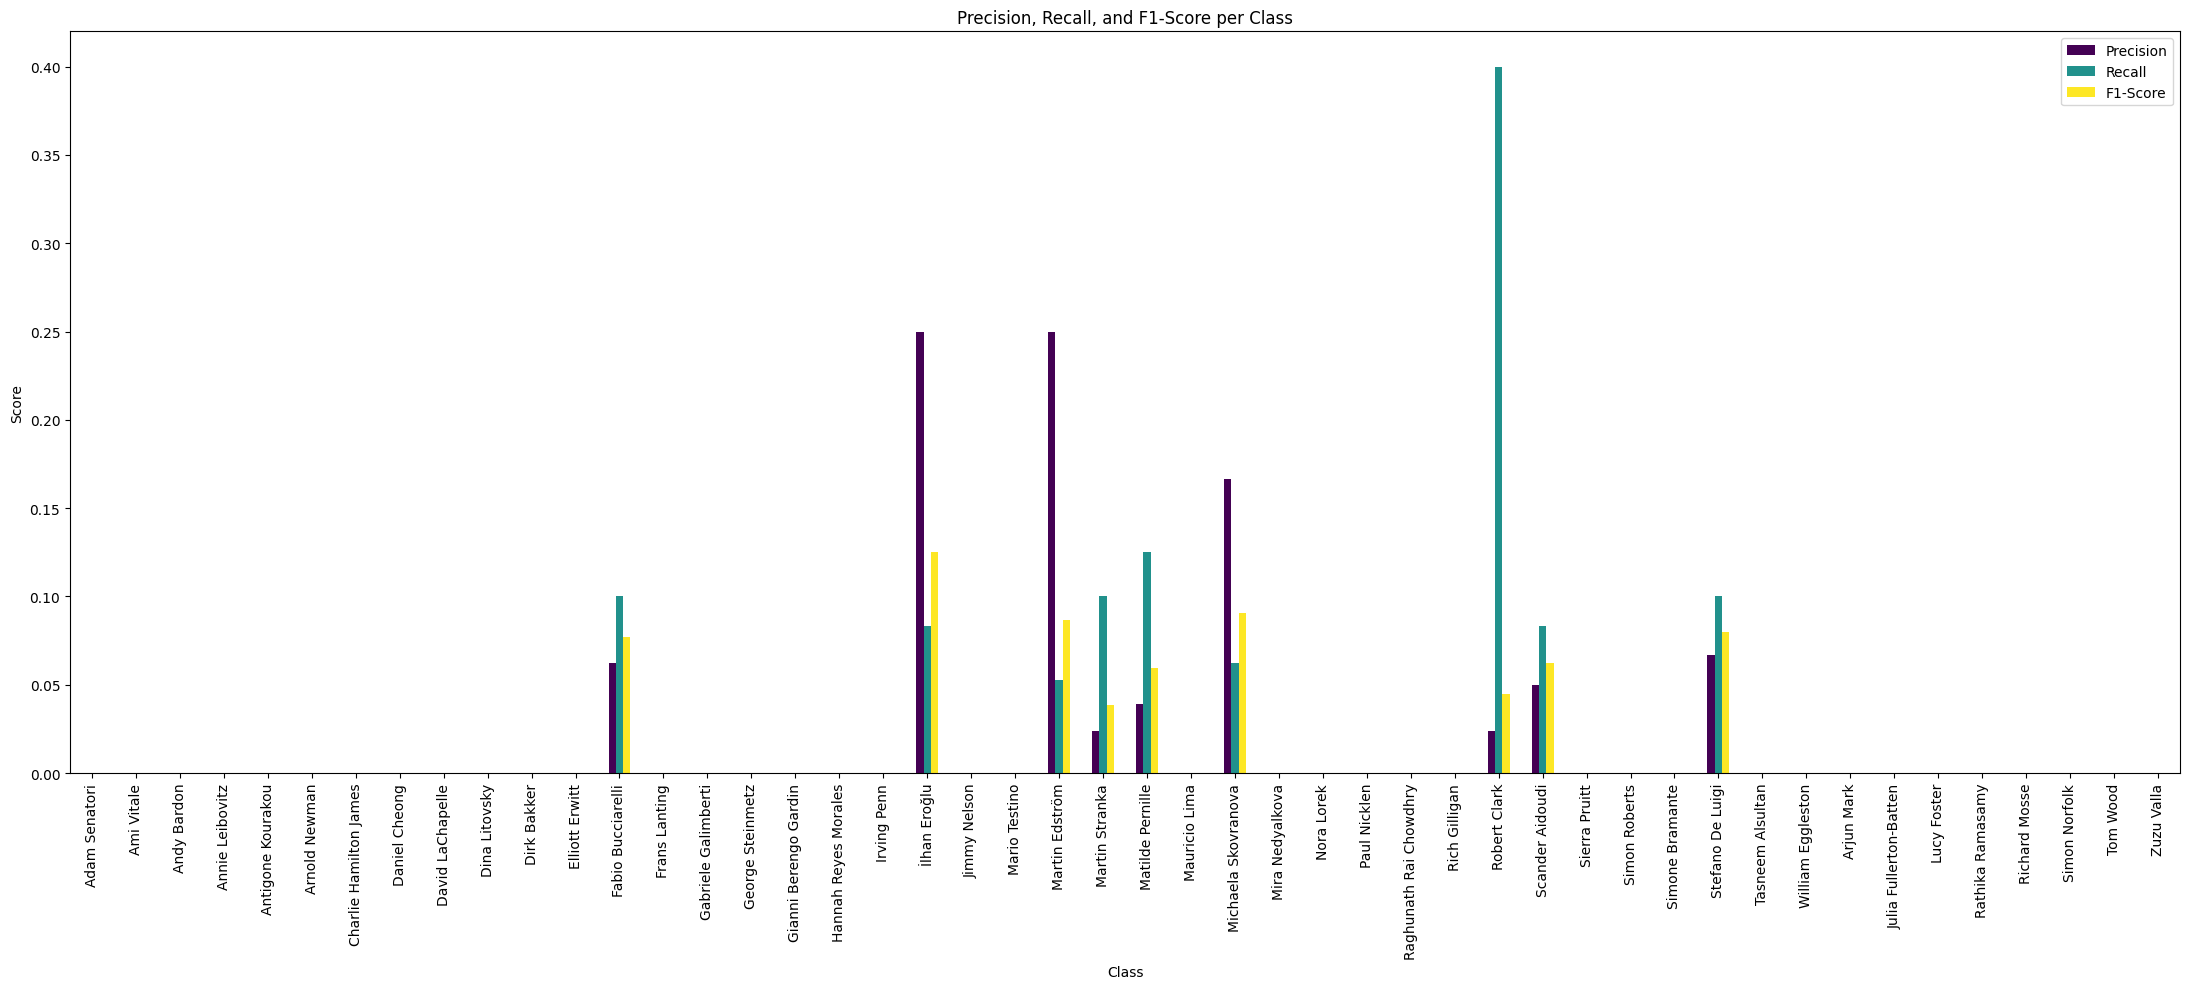

In [ ]:
plt.figure(figsize=(22, 10))
metrics = ['Precision', 'Recall', 'F1-Score']
results_plot = results[metrics]

results_plot.plot(kind='bar', figsize=(22, 10), colormap='viridis')
plt.xticks(rotation=90)
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score per Class')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
